In [36]:
!pip install -q fastai gradio matplotlib
from fastai.vision.all import *
import kagglehub
import matplotlib.pyplot as plt


In [37]:
# Download the data
path = kagglehub.dataset_download("asaniczka/mammals-image-classification-dataset-45-animals")
train_path = Path(path)
print(f"Dataset downloaded to: {path}")
print(f"Content of the dataset directory: {train_path.ls()[:5]}...")


Dataset downloaded to: /kaggle/input/mammals-image-classification-dataset-45-animals
Content of the dataset directory: [Path('/kaggle/input/mammals-image-classification-dataset-45-animals/mammals')]...


In [38]:
 # Create a DataBlock
size = 299
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Explicit validation split
    get_y=parent_label,
    item_tfms=[Resize(int(size*1.2)), RandomCrop(size)],  # Fixed the resizing issue
    batch_tfms=[
        *aug_transforms(size=size, max_warp=0.2, max_lighting=0.3,
                        flip_vert=False, max_rotate=15.0),
        Normalize.from_stats(*imagenet_stats)  # Explicit normalization
    ]
)

# Create dataloaders
dls = data_block.dataloaders(path, bs=16)

In [49]:
#Inspect the DataBlock
print("\nChecking labels:")
print(f"Total classes: {len(dls.vocab)}")



Checking labels:
Total classes: 45


In [50]:
model = vision_learner(dls, resnet50, metrics=[accuracy, error_rate])


Finding optimal learning rate...


SuggestedLRs(minimum=0.0028840314596891405, steep=3.981071756697929e-07)

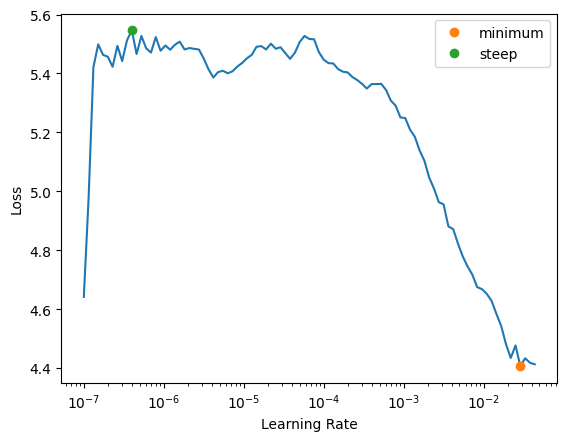

In [51]:
#Learning Rate Finder
print("\nFinding optimal learning rate...")
model.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=1e-1)


In [52]:
# Training With Transfer Learning
# First train only the head
model.fit_one_cycle(3, 3e-3)

# Unfreeze
model.unfreeze()
model.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.969952,0.422574,0.882545,0.117455,00:45
1,0.646650,0.288137,0.922909,0.077091,00:45
2,0.434831,0.217476,0.940727,0.059273,00:45


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.297717,0.207764,0.940000,0.060000,00:54
1,0.332782,0.192096,0.945091,0.054909,00:53
2,0.284858,0.190240,0.943636,0.056364,00:53
3,0.286308,0.192340,0.947273,0.052727,00:53
4,0.213020,0.192408,0.947636,0.052364,00:54



Generating confusion matrix...


<Figure size 2000x2000 with 0 Axes>

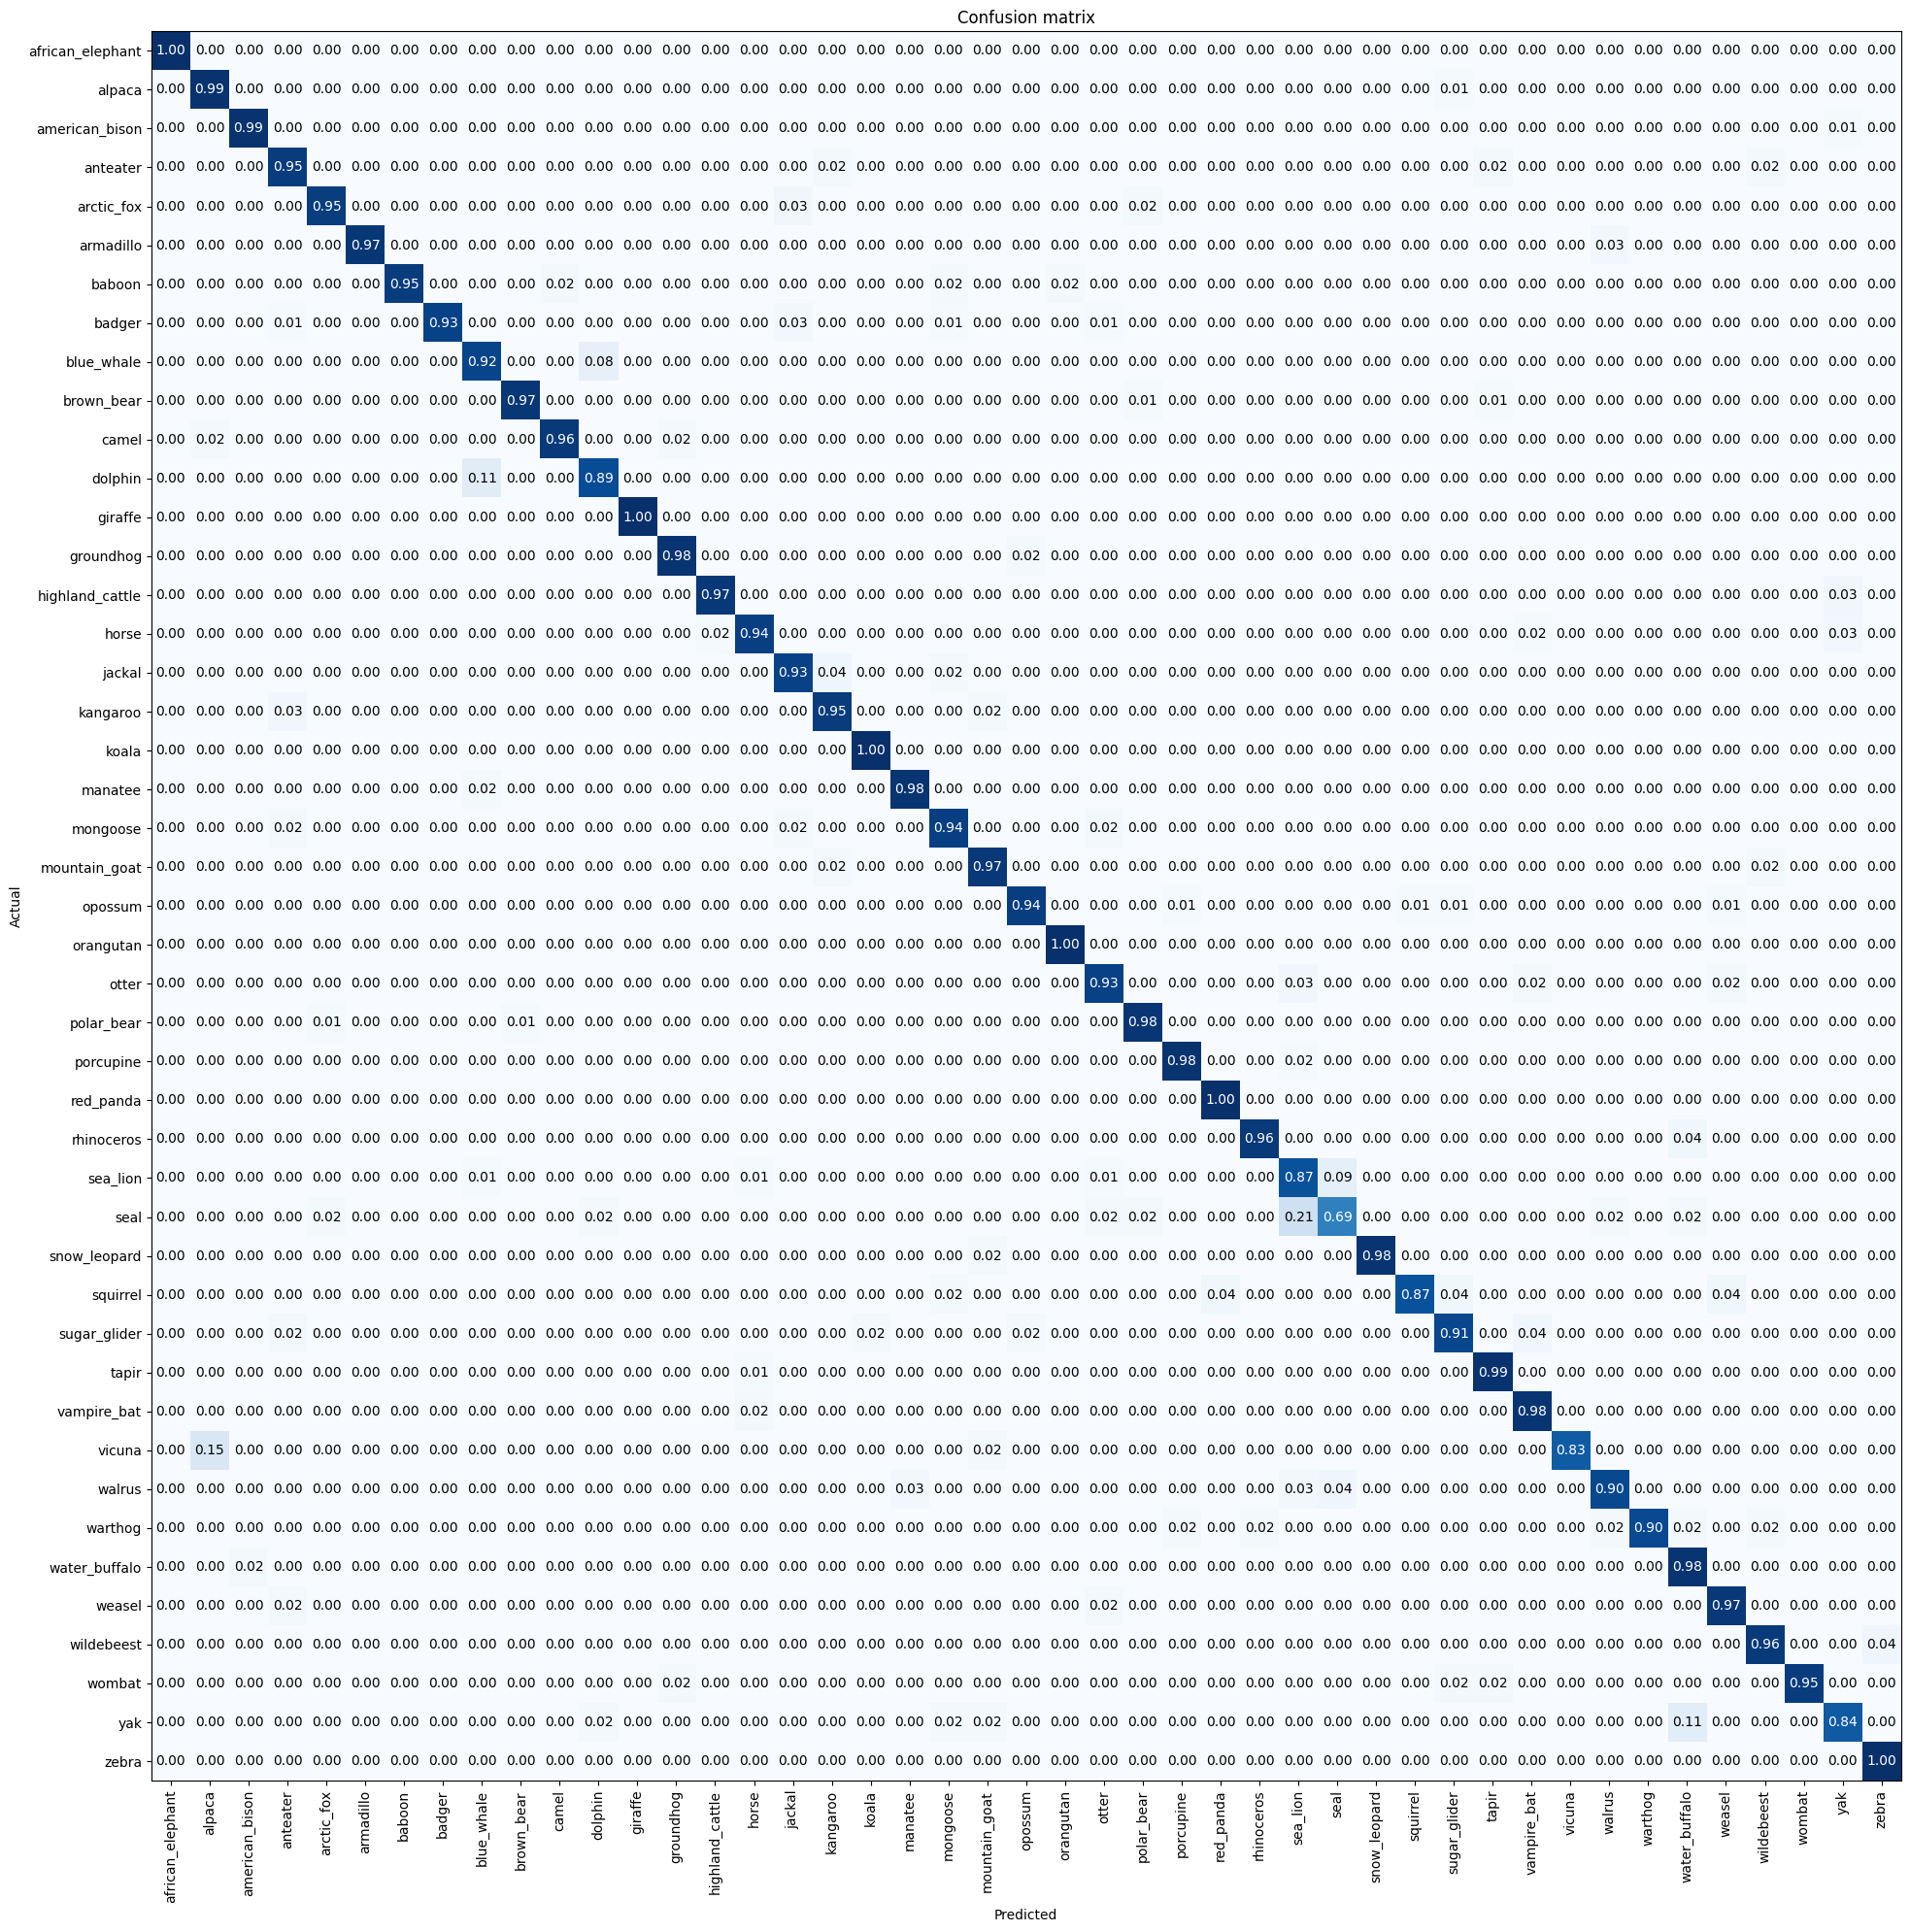

In [53]:
#Confusion matrix visualization
print("\nGenerating confusion matrix...")
interp = ClassificationInterpretation.from_learner(model)
plt.figure(figsize=(20, 20))
interp.plot_confusion_matrix(figsize=(20, 20), normalize=True)
plt.tight_layout()
plt.savefig('improved_confusion_matrix.png', dpi=300)

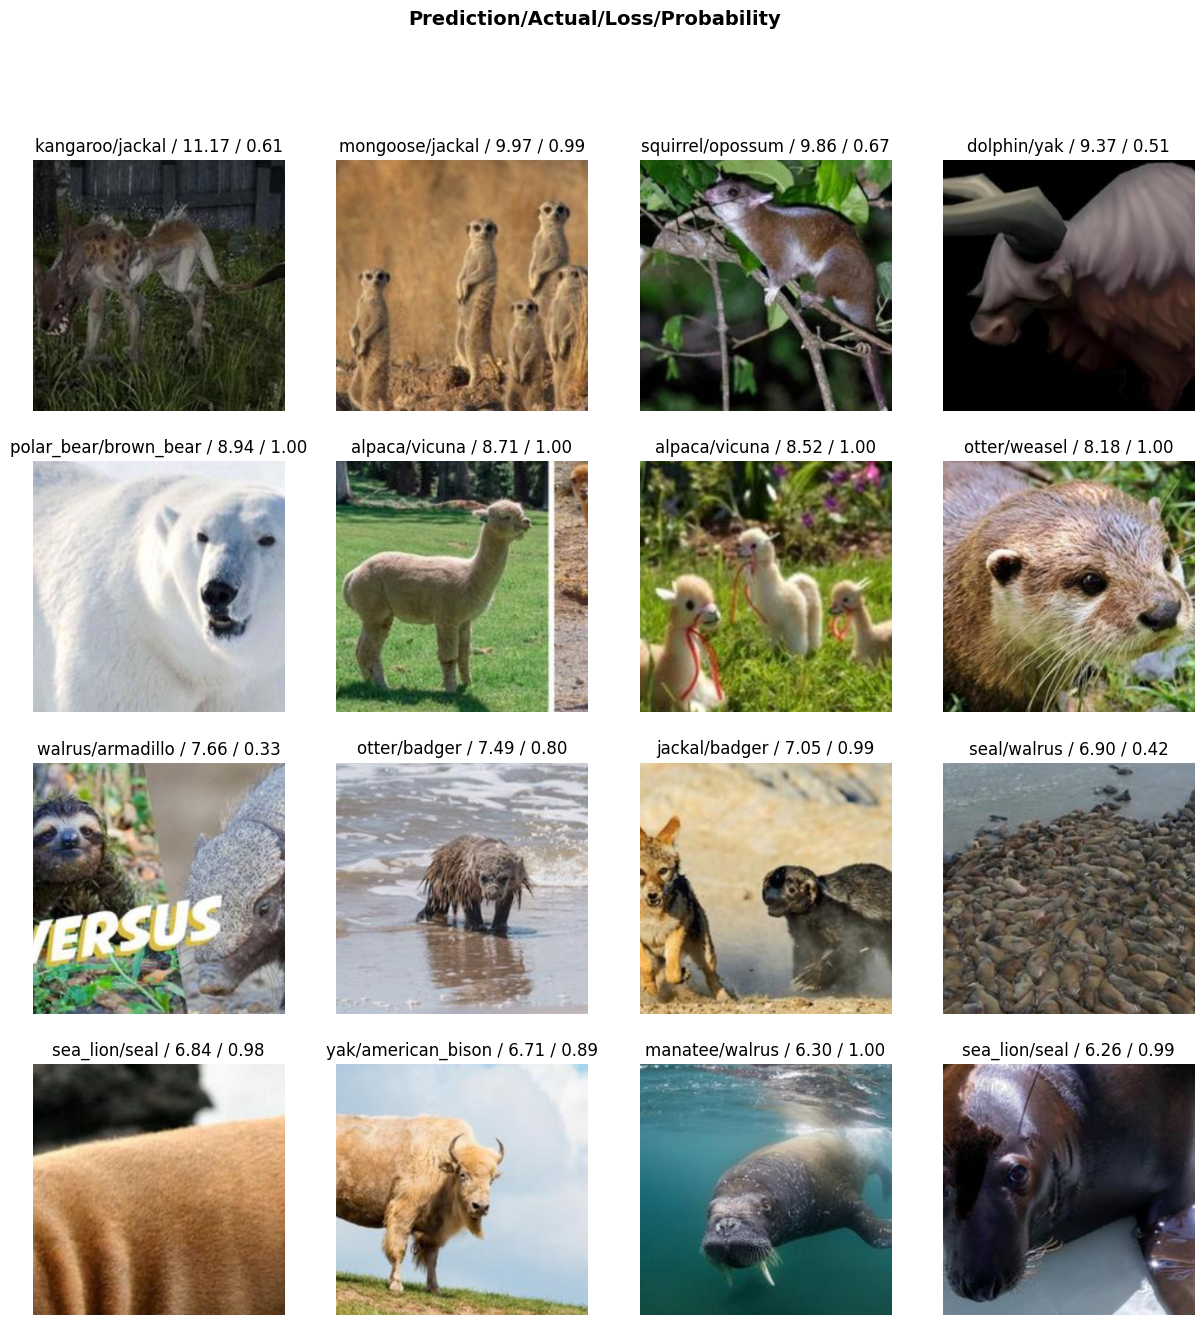

In [54]:
# Plot top losses for analysis
interp.plot_top_losses(16, figsize=(15, 15))
plt.savefig('top_losses.png')

In [55]:
# Export the trained model
model_path = 'Mammals_classifier.pkl'
model.export(model_path)
print(f"\ model exported to {model_path}")

# Add model interpretation
print("\nAnalyzing model predictions...")
from fastai.interpret import ClassificationInterpretation
interpretation = ClassificationInterpretation.from_learner(model)

\ model exported to Mammals_classifier.pkl

Analyzing model predictions...


In [56]:
try:
    import gradio as gr

    def classify_mammals(img):
        img = PILImage.create(img)
        pred_class, pred_idx, probs = model.predict(img)
        top_probs, top_idxs = probs.topk(5)
        return {model.dls.vocab[i]: float(p) for i, p in zip(top_idxs, top_probs)}

    demo = gr.Interface(
        fn=classify_mammals,
        inputs=gr.Image(),
        outputs=gr.Label(),
        title="Mammals Image Classifier",
        description="Upload an image to identify its species"
    )

    print("\nLaunching Gradio interface...")
    demo.launch(share=True)
except Exception as e:
    print(f"\nError creating demo: {e}")
    print("Try installing with: pip install gradio matplotlib")


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6eaa15cd1d811d1ee7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [57]:
model.export("mammals_image_classification.pkl")
from google.colab import files
files.download('mammals_image_classification.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>